In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
pd.options.mode.copy_on_write = True

In [2]:
# Importazione dei file usati per i grafici
conStand = pd.read_csv('../dataSets/constructor_standings.csv')
driveStand = pd.read_csv('../dataSets/driver_standings.csv')
pit = pd.read_csv('../dataSets/pitstops.csv')
raceDet = pd.read_csv('../dataSets/race_details.csv')

Numero di team in Formula 1 per ogni anno

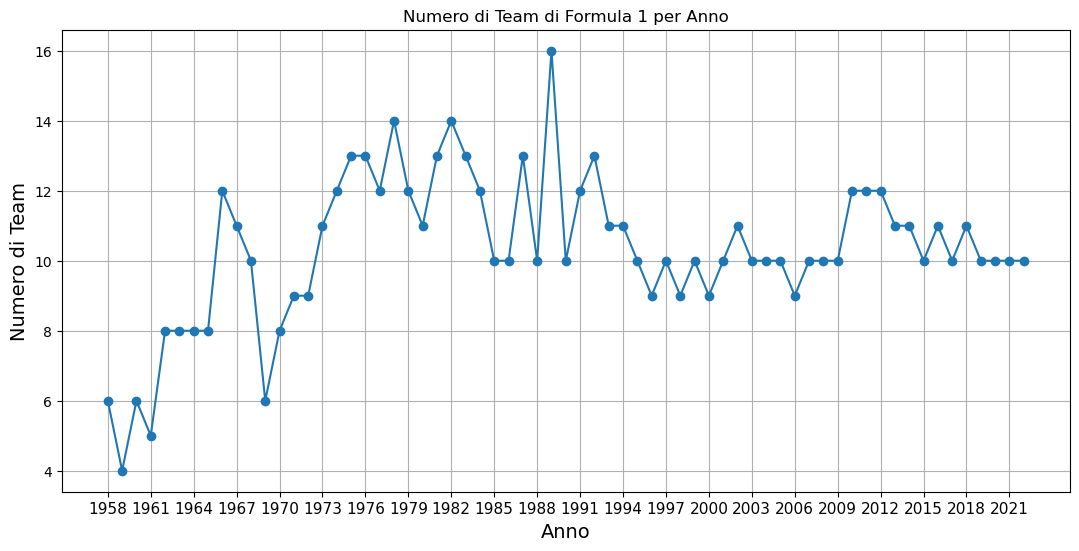

In [3]:
# Conta il numero di team per ogni anno
team_per_anno = conStand.groupby('Year')['Team'].nunique().reset_index()

# Rinomina le colonne per chiarezza
team_per_anno.columns = ['Anno', 'Numero_Team']

# Crea il grafico a linee
plt.figure(figsize=(13, 6))
plt.plot(team_per_anno['Anno'], team_per_anno['Numero_Team'], marker='o', linestyle='-')
plt.title('Numero di Team di Formula 1 per Anno')
plt.xlabel('Anno', fontsize=14)
plt.xticks(team_per_anno['Anno'][::3], fontsize=11)
plt.ylabel('Numero di Team',fontsize=14)
plt.grid(True)
plt.show()

Top 50 team con permanenza più lunga in f1 dal 1958

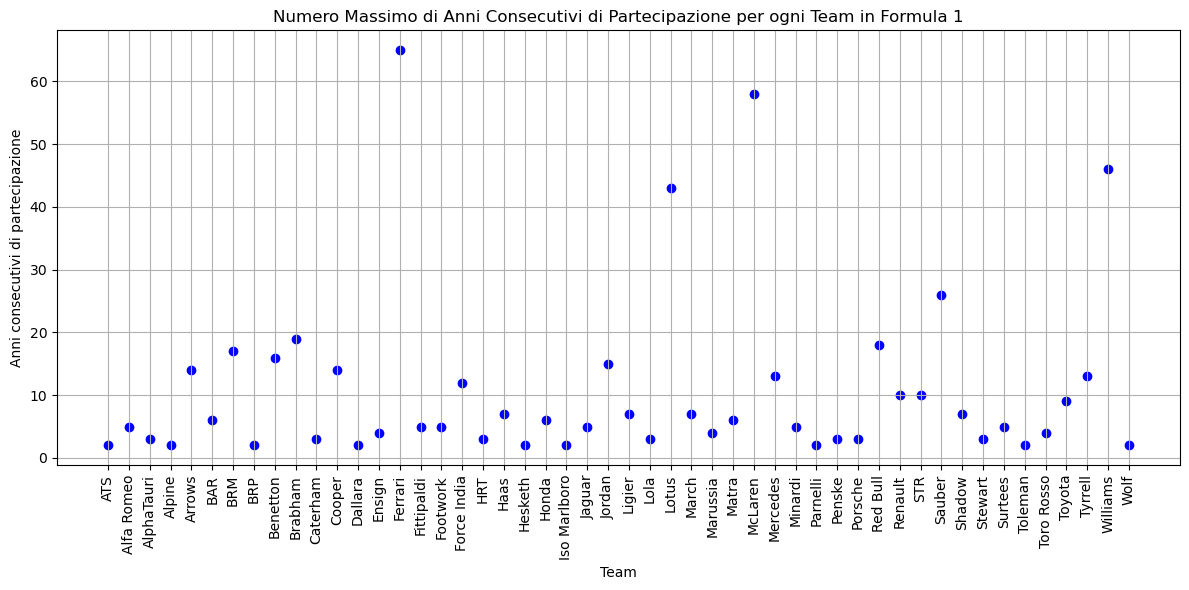

In [4]:
# Calcolcolo delle sequenze consecutive di anni in cui ciascun team è stato presente
def calcola_Anni_Consecutivi(team_conStand):
    team_conStand['Year_Diff'] = team_conStand['Year'].diff().fillna(1)
    team_conStand['Anni_Consecutivi'] = (team_conStand['Year_Diff'] > 1).cumsum()
    consecutive_counts = team_conStand.groupby('Anni_Consecutivi').size()
    return consecutive_counts.max()    

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
conStand['Team Normalizzati'] = conStand['Team'].apply(lambda x: ' '.join(x.split()[:-1]) if len(x.split()) > 1 else x)

# Ordinamento dei team per nome della squadra e per anno
conStand = conStand.sort_values(by=['Team Normalizzati', 'Year'])

# Applicazione della funzione a ciascun team
team_max_consecutivi = conStand.groupby('Team Normalizzati').apply(calcola_Anni_Consecutivi, include_groups=False).reset_index()
team_max_consecutivi.columns = ['Team Normalizzati', 'Max_Anni_Consecutivi']
team_piu_anni = team_max_consecutivi.sort_values(by = 'Max_Anni_Consecutivi', ascending = False).head(50)
team_max_consecutivi = team_max_consecutivi[team_max_consecutivi['Team Normalizzati'].isin(team_piu_anni['Team Normalizzati'])]



# Creazione del grafico a dispersione
plt.figure(figsize=(12, 6))
plt.scatter(team_max_consecutivi['Team Normalizzati'], team_max_consecutivi['Max_Anni_Consecutivi'], color='blue')
plt.xticks(rotation=90)
plt.title('Numero Massimo di Anni Consecutivi di Partecipazione per ogni Team in Formula 1')
plt.xlabel('Team')
plt.ylabel('Anni consecutivi di partecipazione')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 team con più titoli costruttori

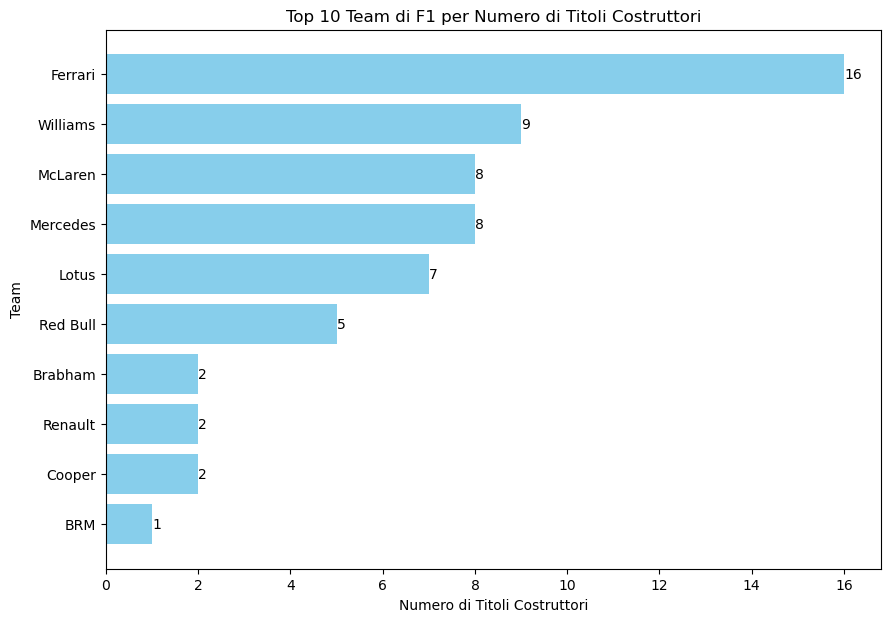

In [5]:
# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
def normalizza_Nomi_Team(nome_Team):
    return ' '.join(nome_Team.split(' ')[:-1]) if len(nome_Team.split(' ')) > 1 else nome_Team

# Conversione di tutti i valori non numerici in 100
conStand['Pos'] = pd.to_numeric(conStand['Pos'], errors='coerce').fillna(100).astype(int)

# Filtraggio dei team che hanno vinto almeno un titolo
vincitori = conStand[conStand['Pos'] == 1]

# Applicazione della normalizzazione ai nomi dei team
vincitori['Team Normalizzati'] = vincitori['Team'].apply(normalizza_Nomi_Team)

# Conteggio del numero di titoli per ogni team 
titoli_Team = vincitori.groupby('Team Normalizzati').size().sort_values(ascending=False)

# Estrazione dei 10 team con più titoli
top_10_team = titoli_Team.head(10)
team = top_10_team.index.tolist()  # Conversione dell'indice in una lista di stringhe
titoli = top_10_team.values

# Creazione del grafico a barre orizzontali
plt.figure(figsize=(10, 7))
plt.barh(team, titoli, color='skyblue')
plt.xlabel('Numero di Titoli Costruttori')
plt.ylabel('Team')
plt.title('Top 10 Team di F1 per Numero di Titoli Costruttori')
plt.gca().invert_yaxis()  # Inversione l'asse Y per avere il primo in alto

for index, value in enumerate(titoli):
    plt.text(value, index, str(value), va='center', ha='left')  # Posiziona il testo all'inizio della barra

plt.show()

top 10 team che hanno vinto il maggior numero di titoli costruttori di fila

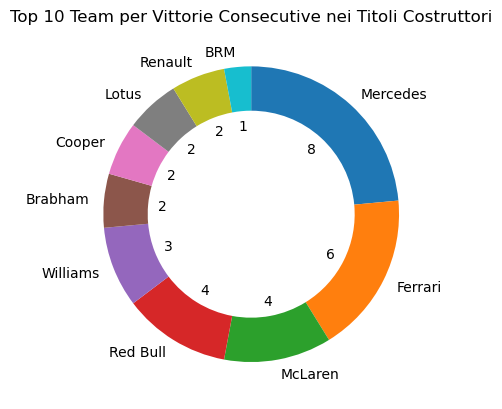

In [6]:
def func(pct, allvals):
    absolute = int(math.ceil(pct/100.*sum(allvals)))
    return "{:d}".format(absolute)

# Conversione di tutti i valori non numerici in 100
conStand['Pos'] = pd.to_numeric(conStand['Pos'], errors='coerce').fillna(100).astype(int)

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
conStand['Team Normalizzati'] = conStand['Team'].apply(lambda x: ' '.join(x.split()[:-1]) if len(x.split()) > 1 else x)

# Filtraggio dei dati per considerare solo i team che hanno vinto
vincitori_conStand = conStand[conStand['Pos'] == 1].sort_values(by='Year')

# variabile per memorizzare il numero di titoli costruttori consecutivi vinti da ogni team nella top 10
vittorie_Consecutive = {}

# Calcolo del numero massimo di vittorie consecutive per ogni team
for team, titoli_Vinti in vincitori_conStand.groupby('Team Normalizzati'):
    titoli_Vinti = titoli_Vinti.sort_values('Year')
    max_Consecutivi = 0
    corrente_Consecutivi = 0
    anno_Precedente = None

    for _, riga in titoli_Vinti.iterrows():
        if anno_Precedente is None or riga['Year'] == anno_Precedente + 1:
            corrente_Consecutivi += 1
        else:
            corrente_Consecutivi = 1

        anno_Precedente = riga['Year']
        max_Consecutivi = max(max_Consecutivi, corrente_Consecutivi)

    vittorie_Consecutive[team] = max_Consecutivi

# Identificazione dei 10 team con le sequenze di vittorie consecutive più lunghe
top_10_team = sorted(vittorie_Consecutive.items(), key=lambda x: x[1], reverse=True)[:10]

# Separazione dei nomi dei team e i loro rispettivi conteggi di vittorie consecutive
team, vittorie = zip(*top_10_team)

# Creazione del grafico ad anello 
fig, ax = plt.subplots()

ax.pie(
    vittorie, 
    labels=team, 
    startangle=90, 
    counterclock=False, 
    wedgeprops=dict(width=0.3),
    autopct=lambda pct: func(pct, vittorie) # Aggiunta i valori numerici direttamente sulle sezioni
)

ax.set(aspect="equal", title='Top 10 Team per Vittorie Consecutive nei Titoli Costruttori')

plt.show()

Costruttori con più mondiali piloti

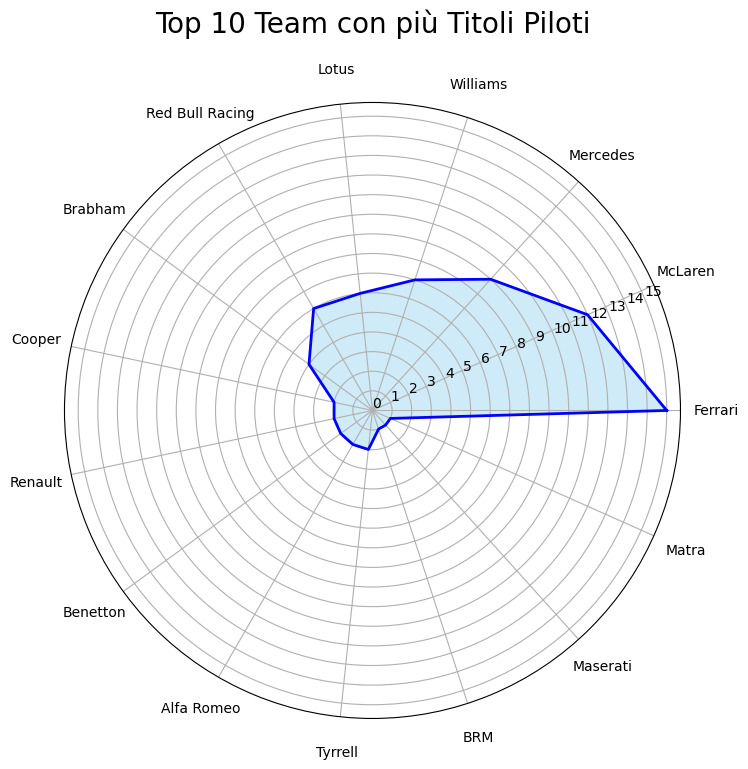

In [7]:
# Raggruppamento dei dati per anno e selezione del pilota con il maggior numero di punti
driveStand['Year'] = driveStand['Year'].astype(int) 
campioni = driveStand.loc[driveStand.groupby('Year')['PTS'].idxmax()]

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
campioni['Team'] = campioni['Car'].apply(lambda x: ' '.join(x.split()[:-1]) if len(x.split()) > 1 else x)

# Conteggio del numero di titoli per ciascun team
titoli_Team = campioni['Team'].value_counts().head(15)

# Impostazione dei dati per il grafico polare
team = titoli_Team.index
titoli = titoli_Team.values

# Conversione dei dati in coordinate per il grafico polare
angoli = np.linspace(0, 2 * np.pi, len(team), endpoint=False).tolist()
angoli += angoli[:1]
titoli = np.append(titoli, titoli[0])

# Creazione del grafico polare
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.fill(angoli, titoli, color='skyblue', alpha=0.4)
ax.plot(angoli, titoli, color='blue', linewidth=2)

# Aggiunta delle etichette con i nomi dei team
ax.set_xticks(angoli[:-1])
ax.set_xticklabels(team)
ax.tick_params(axis='x', which='major', pad=15)

# Aggiunta delle etichette dei valori radiali sugli assi
ax.set_yticks(range(0, max(titoli) + 1))
ax.set_yticklabels(map(str, range(0, max(titoli) + 1)))

plt.title("Top 10 Team con più Titoli Piloti", size=20, y=1.1)

plt.show()

Velocità pit stop dal 1994 al 2009 (rifornimenti concessi)

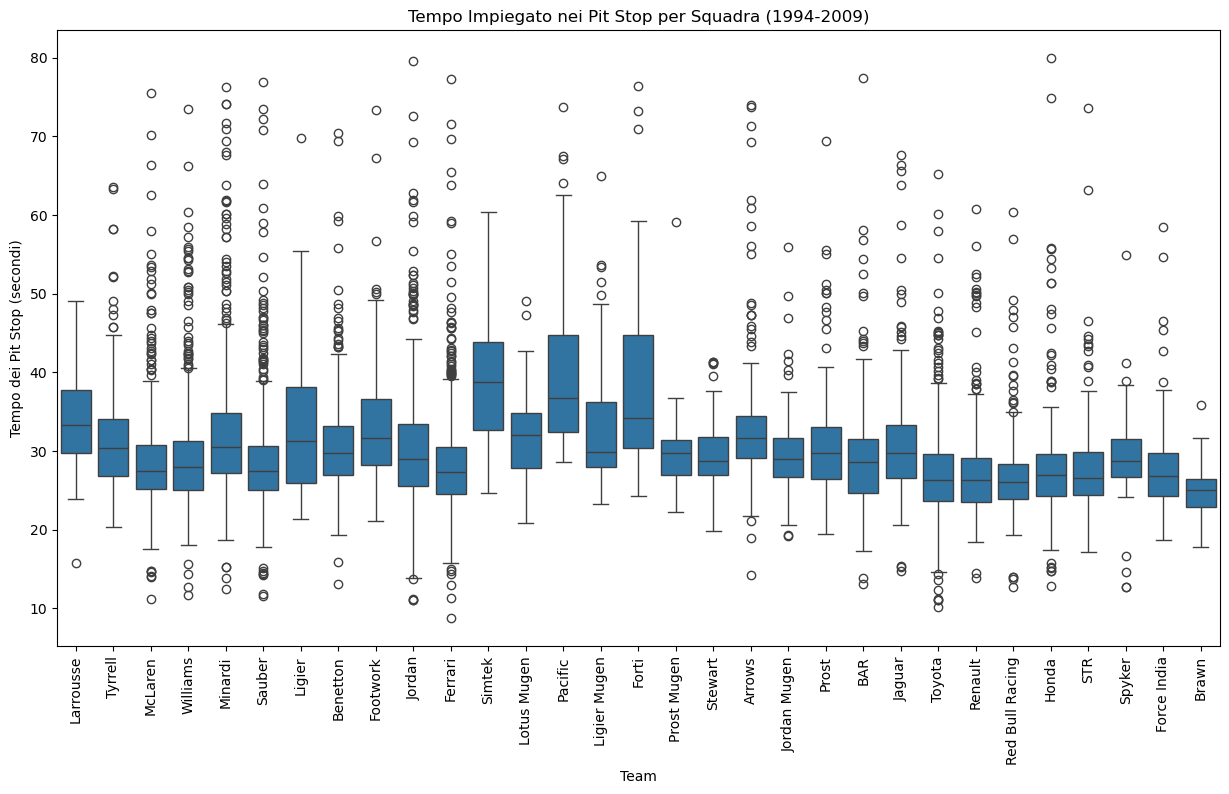

In [8]:
# Conversione dei tempi da minuti e secondi a solo secondi
def conversione_Tempo_In_Secondi(tempo_Str):
    # t1 contiene i secondi se non ci sono minuti; altrimenti contiene i minuti in tempo_Str
    # t2 viene riempito solo se ci sono minuti in tempo_Str e in quel caso contiene i secondi
    t1, *t2 = tempo_Str.split(':')
    return float(t1) if t2 == [] else int(t1) * 60 + float(t2[0])


# Creazione di una variabile locale
pit_local = pit

# Filtraggio dei dati per includere solo i valori dal 1994 al 2009
pit_local = pit_local[pit_local['Year'] <= 2009]

# Rimozione dei valori NaN
pit_local = pit_local.dropna(subset=['Car','Time'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
pit_local['Team'] = pit_local['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

pit_local['TempoPitStopSecondi'] = pit_local['Time'].apply(conversione_Tempo_In_Secondi)
# rimozione dei pit sopra gli 80 secondi (sono eventi come bandiere rosse o auto ritirate dopo essere rimaste del tempo in pitlane)
pit_local = pit_local[pit_local['TempoPitStopSecondi'] < 80]

# Creazione del grafico
plt.figure(figsize=(15, 8))
sns.boxplot(x='Team', y='TempoPitStopSecondi', data=pit_local)
plt.xticks(rotation=90)
plt.title('Tempo Impiegato nei Pit Stop per Squadra (1994-2009)')
plt.xlabel('Team')
plt.ylabel('Tempo dei Pit Stop (secondi)')
plt.show()

Velocità pit stop dal 2010 (rifornimenti banditi)

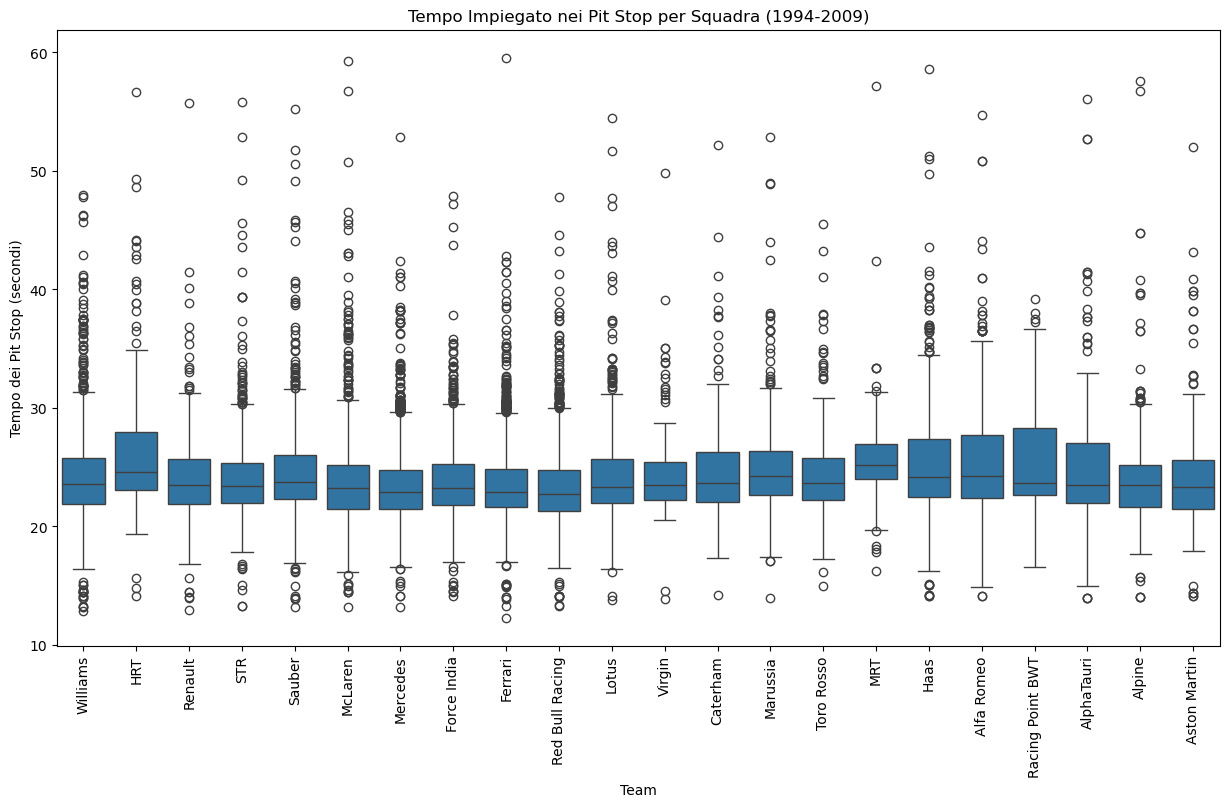

In [9]:
# Conversione dei tempi da minuti e secondi a solo secondi
def conversione_Tempo_In_Secondi(tempo_Str):
    # t1 contiene i secondi se non ci sono minuti; altrimenti contiene i minuti in tempo_Str
    # t2 viene riempito solo se ci sono minuti in tempo_Str e in quel caso contiene i secondi
    t1, *t2 = tempo_Str.split(':')
    return float(t1) if t2 == [] else int(t1) * 60 + float(t2[0])


# Creazione di una variabile locale
pit_local = pit

# Filtraggio dei dati per includere solo i valori oltre il 2009
pit_local = pit_local[pit_local['Year'] > 2009]

# Rimozione dei valori NaN
pit_local = pit_local.dropna(subset=['Car','Time'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
pit_local['Team'] = pit_local['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

pit_local['TempoPitStopSecondi'] = pit_local['Time'].apply(conversione_Tempo_In_Secondi)
# rimozione dei pit sopra i 60 secondi (sono eventi come bandiere rosse o auto ritirate dopo essere rimaste del tempo in pitlane)
pit_local = pit_local[pit_local['TempoPitStopSecondi'] < 60]

# Creazione del grafico
plt.figure(figsize=(15, 8))
sns.boxplot(x='Team', y='TempoPitStopSecondi', data=pit_local)
plt.xticks(rotation=90)
plt.title('Tempo Impiegato nei Pit Stop per Squadra (1994-2009)')
plt.xlabel('Team')
plt.ylabel('Tempo dei Pit Stop (secondi)')
plt.show()

Numero macchine ritirate per anno (motori ibridi)

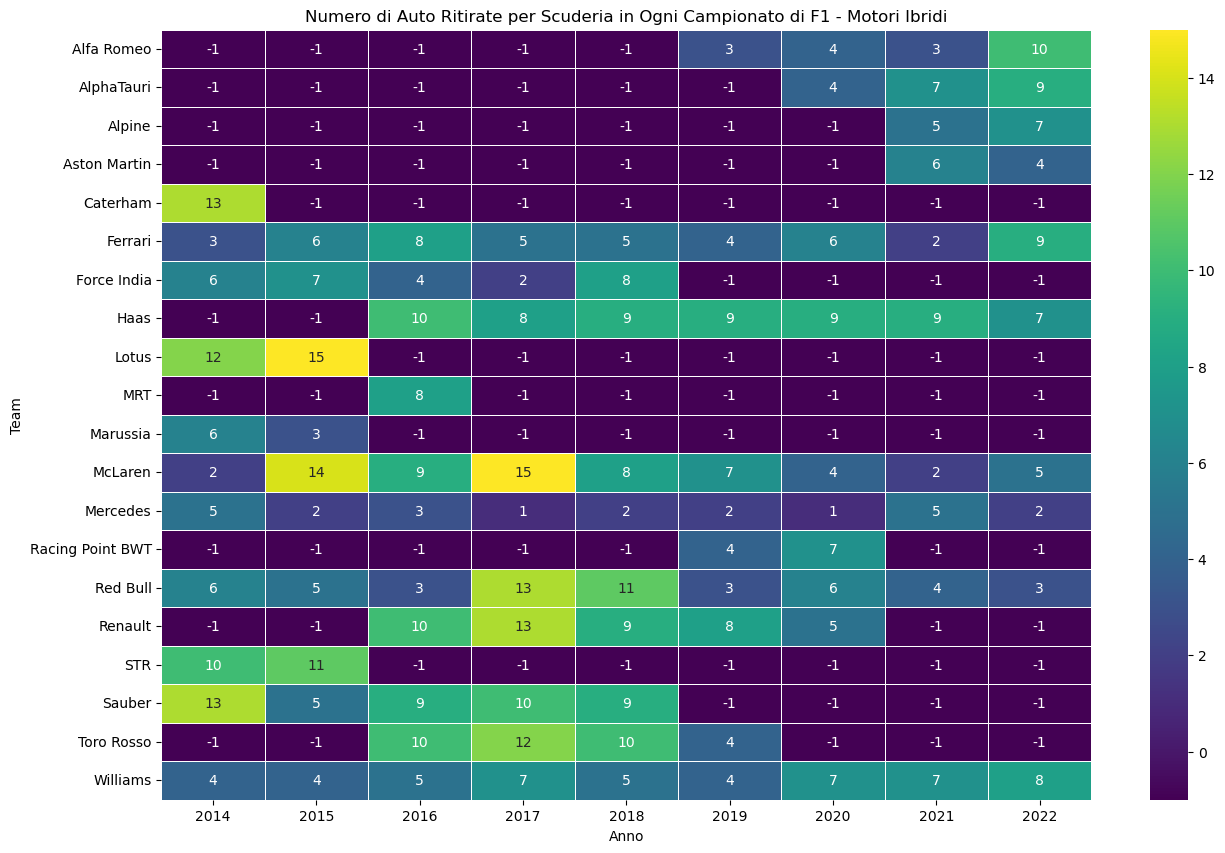

In [10]:
# Filtraggio solo le auto ritirate nell'era dei motori ibridi (dal 2014 in poi)
ritirate = raceDet[(~raceDet['Pos'].str.isdigit()) & (raceDet['Year'] >= 2014)]

ritirate = ritirate.dropna(subset=['Car'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
ritirate['Team'] = ritirate['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# Raggruppamento per team e anno con conteggio dei ritiri
ritirate_Conteggio = ritirate.groupby(['Year', 'Team']).size().reset_index(name='RetiredCount')

# Pivot per creare la matrice per la heatmap
heatmap_data = ritirate_Conteggio.pivot(index='Team', columns='Year', values='RetiredCount')

# Sostituisce i valori NaN con -1 (squadre che non hanno partecipato in un dato anno)
heatmap_data = heatmap_data.fillna(-1)

# Creazione della heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
plt.title('Numero di Auto Ritirate per Scuderia in Ogni Campionato di F1 - Motori Ibridi')
plt.xlabel('Anno')
plt.ylabel('Team')
plt.show()

Numero macchine ritirate per anno (motori V8)

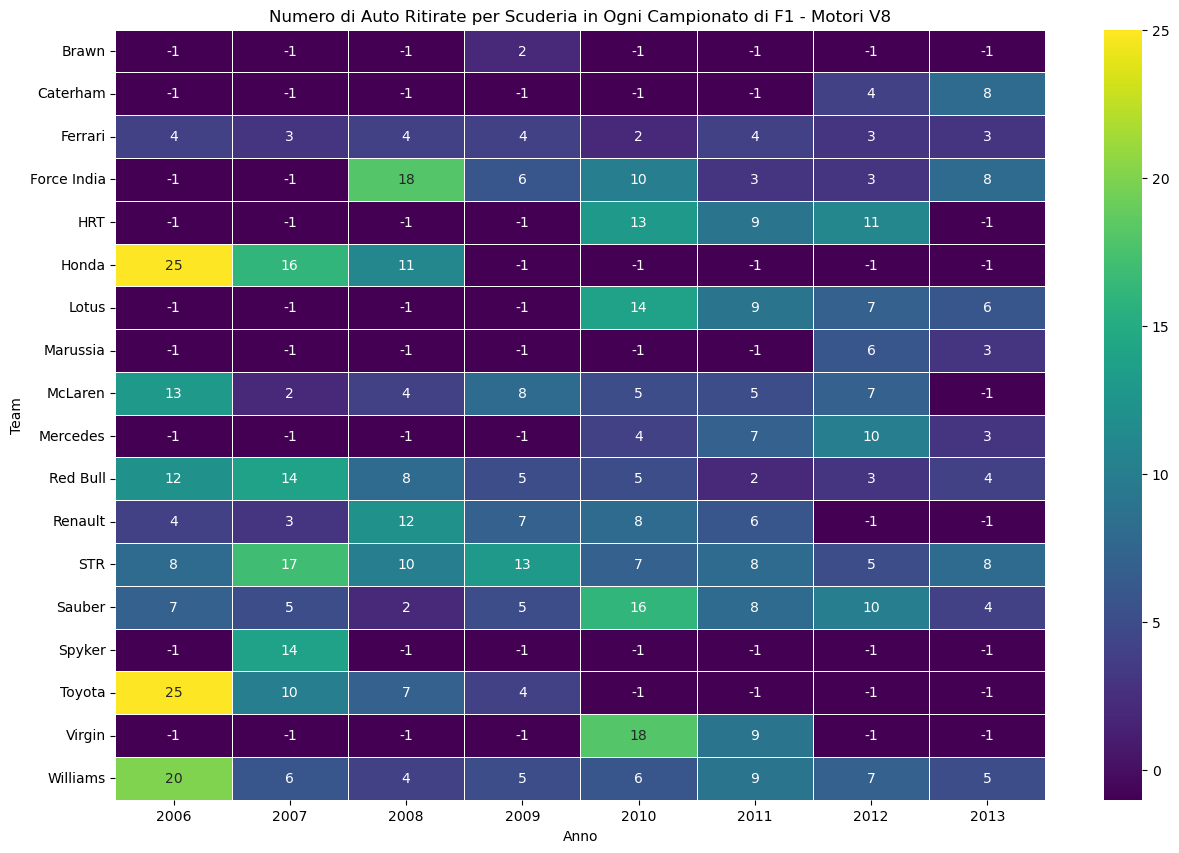

In [11]:
# Filtraggio solo le auto ritirate nell'era dei motori v8 (2006-2014)
ritirate = raceDet[(~raceDet['Pos'].str.isdigit()) & (raceDet['Year'] >= 2006) & (raceDet['Year'] < 2014)]

ritirate = ritirate.dropna(subset=['Car'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
ritirate['Team'] = ritirate['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# Raggruppamento per team e anno con conteggio dei ritiri
ritirate_Conteggio = ritirate.groupby(['Year', 'Team']).size().reset_index(name='RetiredCount')

# Pivot per creare la matrice per la heatmap
heatmap_data = ritirate_Conteggio.pivot(index='Team', columns='Year', values='RetiredCount')

# Sostituisce i valori NaN con -1 (squadre che non hanno partecipato in un dato anno)
heatmap_data = heatmap_data.fillna(-1)

# Creazione della heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
plt.title('Numero di Auto Ritirate per Scuderia in Ogni Campionato di F1 - Motori V8')
plt.xlabel('Anno')
plt.ylabel('Team')
plt.show()

Numero macchine ritirate per anno (motori V10)

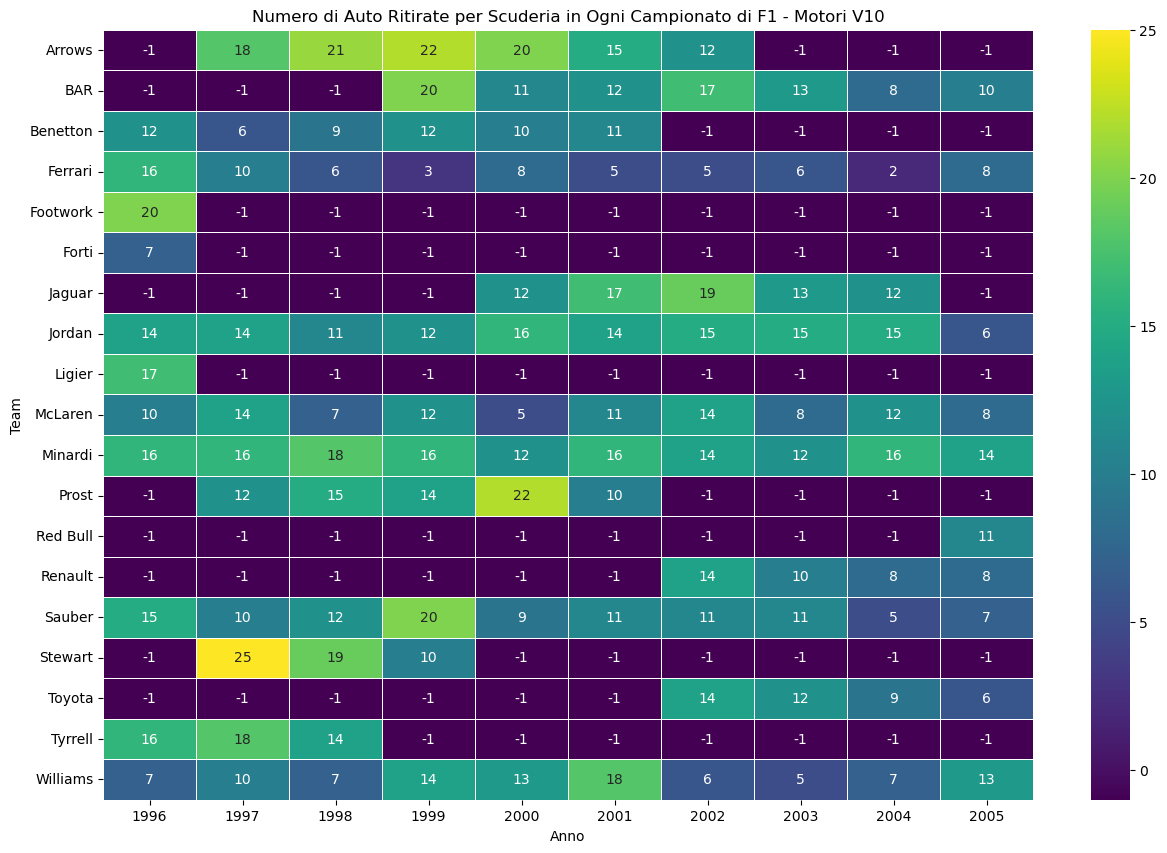

In [12]:
# Filtraggio solo le auto ritirate nell'era dei motori v10 (1996-2006)
ritirate = raceDet[(~raceDet['Pos'].str.isdigit()) & (raceDet['Year'] >= 1996) & (raceDet['Year'] < 2006)]

ritirate = ritirate.dropna(subset=['Car'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
ritirate['Team'] = ritirate['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# Raggruppamento per team e anno con conteggio dei ritiri
ritirate_Conteggio = ritirate.groupby(['Year', 'Team']).size().reset_index(name='RetiredCount')

# Pivot per creare la matrice per la heatmap
heatmap_data = ritirate_Conteggio.pivot(index='Team', columns='Year', values='RetiredCount')

# Sostituisce i valori NaN con -1 (squadre che non hanno partecipato in un dato anno)
heatmap_data = heatmap_data.fillna(-1)

# Creazione della heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
plt.title('Numero di Auto Ritirate per Scuderia in Ogni Campionato di F1 - Motori V10')
plt.xlabel('Anno')
plt.ylabel('Team')
plt.show()

Numero macchine ritirate per anno (epoca turbo e post turbo)

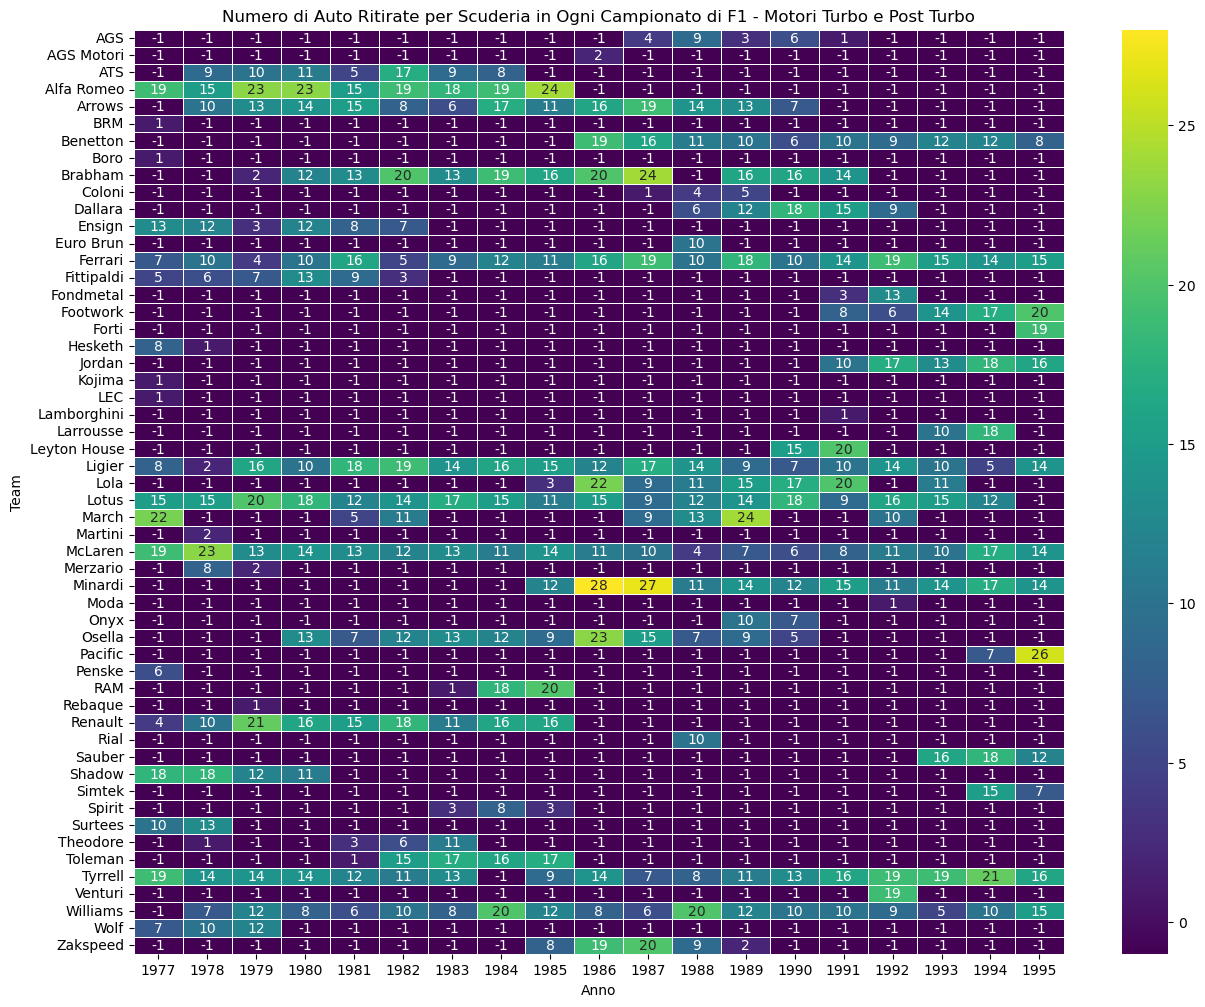

In [13]:
# Filtraggio solo le auto ritirate nell'era dei motori turbo (1977-1995)
ritirate = raceDet[(~raceDet['Pos'].str.isdigit()) & (raceDet['Year'] >= 1977) & (raceDet['Year'] < 1996)]

ritirate = ritirate.dropna(subset=['Car'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
ritirate['Team'] = ritirate['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# Raggruppamento per team e anno con conteggio dei ritiri
ritirate_Conteggio = ritirate.groupby(['Year', 'Team']).size().reset_index(name='RetiredCount')

# Pivot per creare la matrice per la heatmap
heatmap_data = ritirate_Conteggio.pivot(index='Team', columns='Year', values='RetiredCount')

# Sostituisce i valori NaN con -1 (squadre che non hanno partecipato in un dato anno)
heatmap_data = heatmap_data.fillna(-1)

# Creazione della heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
plt.title('Numero di Auto Ritirate per Scuderia in Ogni Campionato di F1 - Motori Turbo e Post Turbo')
plt.xlabel('Anno')
plt.ylabel('Team')
plt.show()

Numero macchine ritirate per anno (motori liberi 1965-1976)

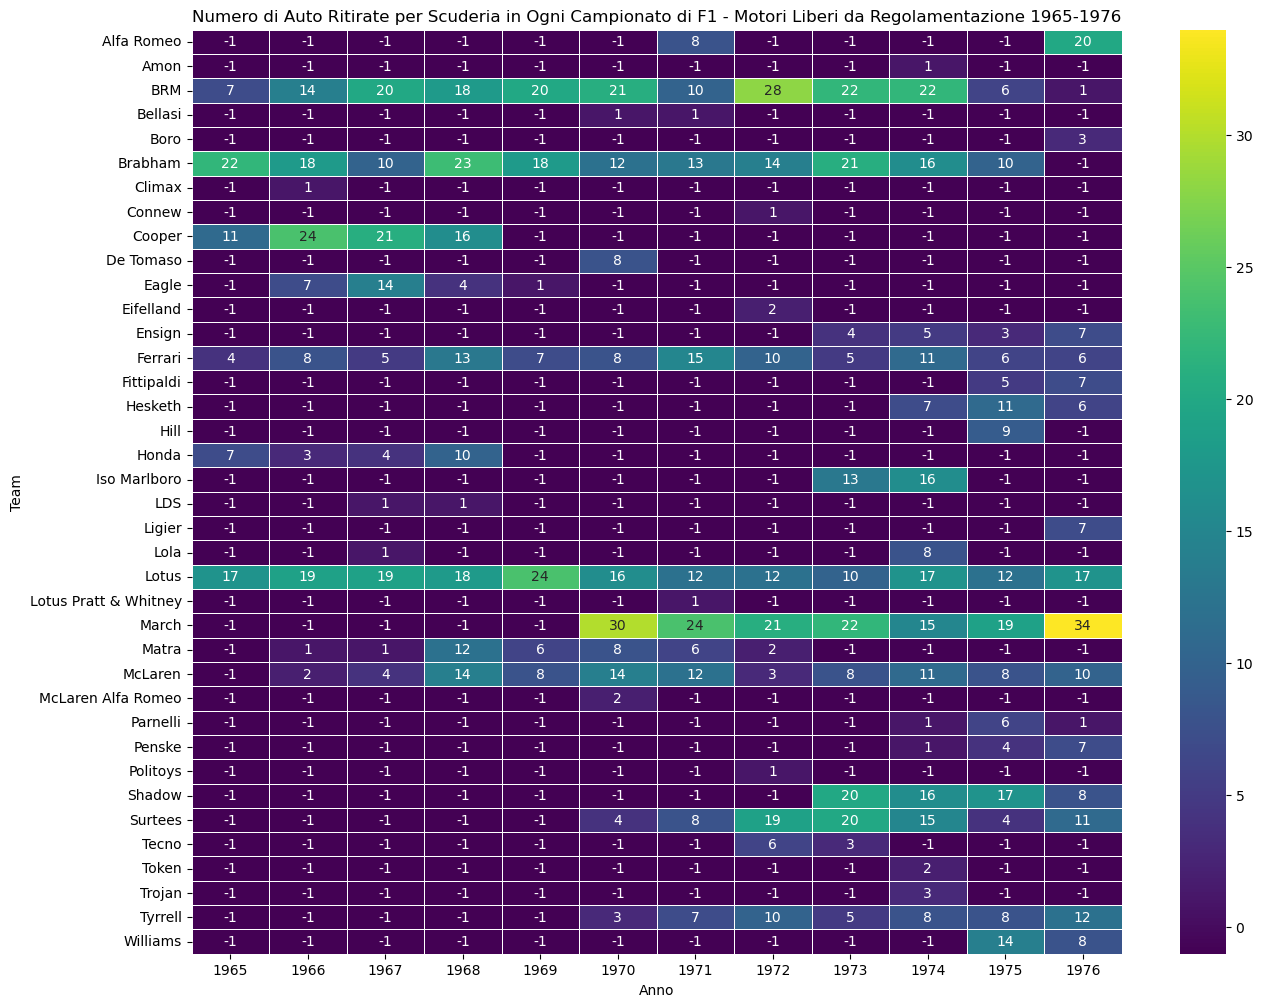

In [14]:
# Filtraggio solo le auto ritirate nell'era dei motori liberi da regolamentazione (pt.2: 1965-1976)
ritirate = raceDet[(~raceDet['Pos'].str.isdigit()) & (raceDet['Year'] >= 1965) & (raceDet['Year'] < 1977)]

ritirate = ritirate.dropna(subset=['Car'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
ritirate['Team'] = ritirate['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# Raggruppamento per team e anno con conteggio dei ritiri
ritirate_Conteggio = ritirate.groupby(['Year', 'Team']).size().reset_index(name='RetiredCount')

# Pivot per creare la matrice per la heatmap
heatmap_data = ritirate_Conteggio.pivot(index='Team', columns='Year', values='RetiredCount')

# Sostituisce i valori NaN con -1 (squadre che non hanno partecipato in un dato anno)
heatmap_data = heatmap_data.fillna(-1)

# Creazione della heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
plt.title('Numero di Auto Ritirate per Scuderia in Ogni Campionato di F1 - Motori Liberi da Regolamentazione 1965-1976')
plt.xlabel('Anno')
plt.ylabel('Team')
plt.show()

Numero macchine ritirate per anno (motori liberi 1950-1964)

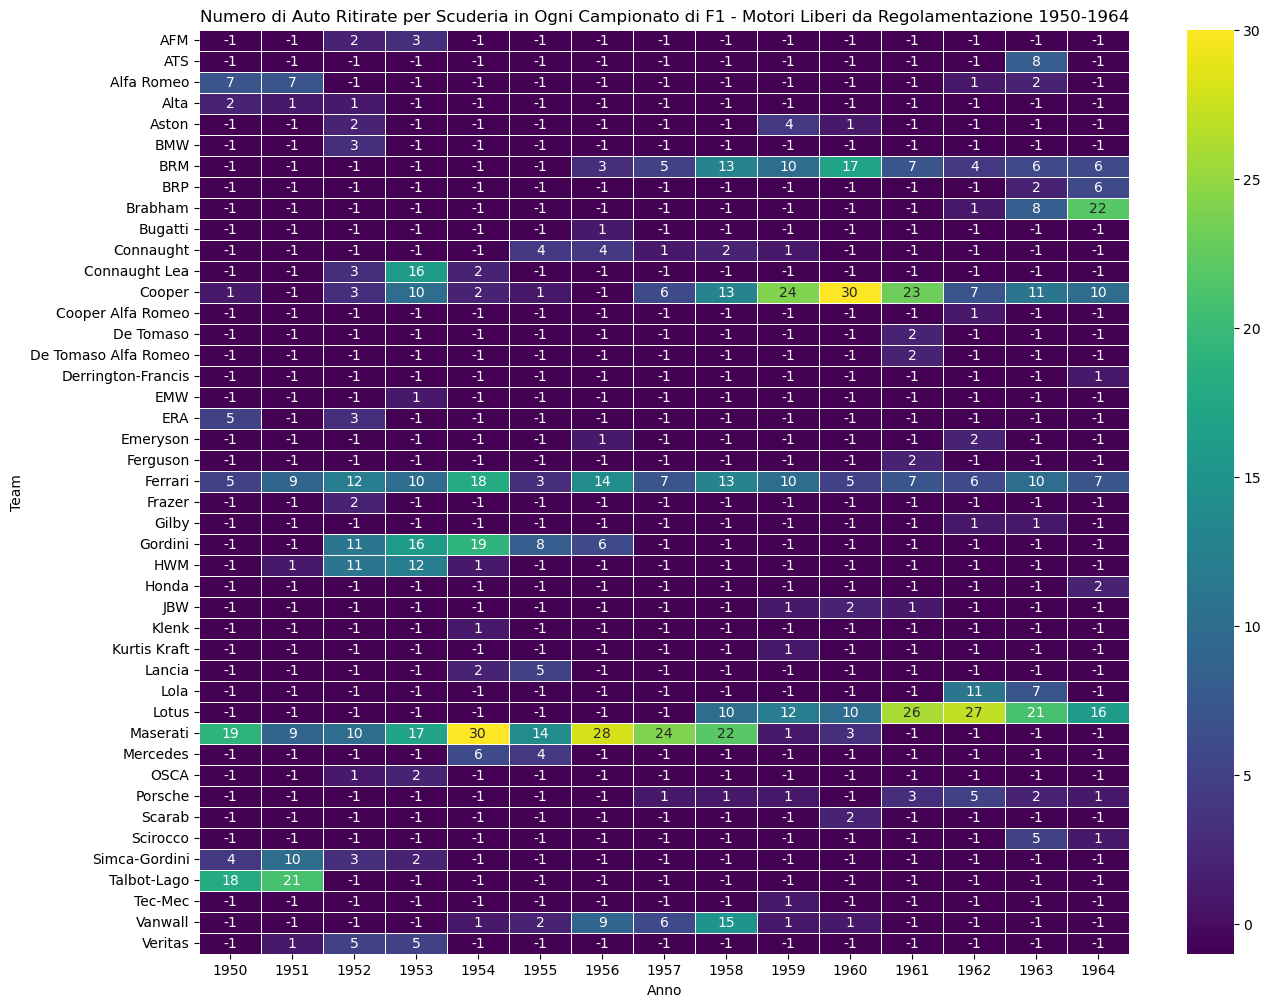

In [15]:
# Filtraggio solo le auto ritirate nell'era dei motori liberi da regolamentazione (pt.1: 1950-1964)
ritirate = raceDet[(~raceDet['Pos'].str.isdigit()) & (raceDet['Year'] < 1965)]

ritirate = ritirate.dropna(subset=['Car'])

# Rimozione dei nomi degli sponsor/dei motoristi dal nome dei team
ritirate['Team'] = ritirate['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# Raggruppamento per team e anno con conteggio dei ritiri
ritirate_Conteggio = ritirate.groupby(['Year', 'Team']).size().reset_index(name='RetiredCount')

# Pivot per creare la matrice per la heatmap
heatmap_data = ritirate_Conteggio.pivot(index='Team', columns='Year', values='RetiredCount')

# Sostituisce i valori NaN con -1 (squadre che non hanno partecipato in un dato anno)
heatmap_data = heatmap_data.fillna(-1)

# Creazione della heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
plt.title('Numero di Auto Ritirate per Scuderia in Ogni Campionato di F1 - Motori Liberi da Regolamentazione 1950-1964')
plt.xlabel('Anno')
plt.ylabel('Team')
plt.show()